# Comparison of output from coupled surface- and soil- bmis and PRMS6.
PRMS6 is decoupled into 4 bmis including Surface, Soil, Groundwater and Streamflow.  The purpose of this notebook is to compare the output from a coupled surface-soil model with PRMS6.  An example of the Fortran code for this coupling is below and the full code can be found here [ifr_ex](https://github.com/nhm-usgs/bmi-prms6-soil/blob/master/examples/irf_ex.f90):

```
  use bmif_2_0, only: BMI_MAX_UNITS_NAME, BMI_SUCCESS, BMI_FAILURE
  use bmiprmssurface
  use bmiprmssoil
  implicit none

  type (bmi_prms_surface) :: m_surf
  type (bmi_prms_soil) :: m_soil
  integer :: s, i
  double precision :: time, time0, time1
  character (len=BMI_MAX_UNITS_NAME) :: time_units
  character (len=*), parameter :: control_file = './pipestem/control.simple1'
  character (len=*), parameter :: control_file1 = './pipestem_surface/control.simple1'
  character (len=*), parameter :: control_file2 = './pipestem_soil/control.simple1'
  double precision :: endtime

  write (*,"(a)",advance="no") "Initializing..."
  s = m_surf%initialize(control_file1)
  s = m_soil%initialize(control_file2)
  
  s = m_surf%get_end_time(endtime)
  
  do i = 1,int(endtime)
      s = m_surf%update()
      s = surface2soil(m_surf, m_soil)
      s = m_soil%update()
      s = soil2surface(m_surf, m_soil)
  enddo
  write (*,*) "Done."


  write (*,"(a)", advance="no") "Finalizing..."
  s = m_surf%finalize()
  s = m_soil%finalize()
  write (*,*) "Done"
```


In [2]:
# code for specific functions in this notebook. See repo Readme.md for install instructions
import prms6bmi

In [3]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Set the paths to the summary_daily.nc (NetCDF) files and read into [xarray](http://xarray.pydata.org/en/stable/)

In [4]:
soil_file = Path('B:/gitbmi/bmi-prms6-soil/bmi_prms_soil\irf_ex/pipestem_soil/output/summary_daily.nc')
surf_file = Path('B:/gitbmi/bmi-prms6-soil/bmi_prms_soil/irf_ex/pipestem_surface/output/summary_daily.nc')
prms_file = Path('B:/gitbmi/prms/_build/prms/pipestem/output/summary_daily.nc')
clim_file = Path('B:/gitbmi/prms/_build/prms/pipestem/daymet.nc')
dsoil = xr.open_dataset(soil_file)
dprms = xr.open_dataset(prms_file)
dsurf = xr.open_dataset(surf_file)
clim = xr.open_dataset(clim_file)

### Print min/max dates of climate forcing data and then print some meta-data

In [5]:
clim_date_min = clim.time.min().values
clim_date_max = clim.time.max().values
print(clim_date_min, clim_date_max)
clim

1980-01-01T00:00:00.000000000 2016-12-31T00:00:00.000000000


<xarray.Dataset>
Dimensions:  (hru: 14, time: 13515)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2016-12-31
  * hru      (hru) int32 57874 57875 57878 57881 ... 57869 57870 57864 57865
Data variables:
    prcp     (time, hru) float32 ...
    tmax     (time, hru) float32 ...
    tmin     (time, hru) float32 ...
Attributes:
    Description:                Climate by HRU
    Bandit_version:             0.6.3
    NHM_version:                ff1b7fc29610bac9f5daa1ca0563d9f6962ddcf0
    history:                    Mon Apr  8 10:11:53 2019: ncks -A tmin.nc day...
    history_of_appended_files:  Mon Apr  8 10:11:53 2019: Appended file tmin....
    NCO:                        netCDF Operators version 4.7.8 (Homepage = ht...

### Print min/max dates of of the bmi-soil simulation and then print some meta-data

In [6]:
sim_start_date = dsoil.time.min()
sim_end_date = dsoil.time.max()
dsoil

<xarray.Dataset>
Dimensions:              (nhru: 14, nsegment: 7, time: 731)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 1981-12-31
Dimensions without coordinates: nhru, nsegment
Data variables:
    nhm_id               (nhru) int32 ...
    nhm_seg              (nsegment) int32 ...
    hru_actet            (time, nhru) float32 ...
    hru_impervevap       (time, nhru) float32 ...
    hru_intcpevap        (time, nhru) float32 ...
    snow_evap            (time, nhru) float32 ...
    perv_actet           (time, nhru) float32 ...
    slow_flow            (time, nhru) float32 ...
    recharge             (time, nhru) float32 ...
    soil_moist           (time, nhru) float32 ...
    soil_to_gw           (time, nhru) float32 ...
    ssr_to_gw            (time, nhru) float32 ...
    dprst_seep_hru       (time, nhru) float64 ...
    dprst_evap_hru       (time, nhru) float32 ...
    infil                (time, nhru) float32 ...
    sroff                (time, nhru

### Print min/max dates of of the surface-bmi simulation and then print some meta-data

In [7]:
dsurf

<xarray.Dataset>
Dimensions:              (nhru: 14, nsegment: 7, time: 731)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 1981-12-31
Dimensions without coordinates: nhru, nsegment
Data variables:
    nhm_id               (nhru) int32 ...
    nhm_seg              (nsegment) int32 ...
    hru_actet            (time, nhru) float32 ...
    hru_impervevap       (time, nhru) float32 ...
    hru_intcpevap        (time, nhru) float32 ...
    snow_evap            (time, nhru) float32 ...
    perv_actet           (time, nhru) float32 ...
    slow_flow            (time, nhru) float32 ...
    recharge             (time, nhru) float32 ...
    soil_moist           (time, nhru) float32 ...
    soil_to_gw           (time, nhru) float32 ...
    ssr_to_gw            (time, nhru) float32 ...
    dprst_seep_hru       (time, nhru) float64 ...
    dprst_evap_hru       (time, nhru) float32 ...
    infil                (time, nhru) float32 ...
    sroff                (time, nhru

In [8]:
### Print min/max dates of of the PRMS6 simulation and then print some meta-data

In [9]:
print(dprms.nhm_id)
dprms

<xarray.DataArray 'nhm_id' (nhru: 14)>
array([57874, 57875, 57878, 57881, 57868, 57873, 57879, 57880, 57882, 57883,
       57869, 57870, 57864, 57865])
Dimensions without coordinates: nhru
Attributes:
    long_name:  NHM HRU id
    units:      none


<xarray.Dataset>
Dimensions:              (nhru: 14, nsegment: 7, time: 731)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 1981-12-31
Dimensions without coordinates: nhru, nsegment
Data variables:
    nhm_id               (nhru) int32 57874 57875 57878 ... 57870 57864 57865
    nhm_seg              (nsegment) int32 ...
    hru_actet            (time, nhru) float32 ...
    hru_impervevap       (time, nhru) float32 ...
    hru_intcpevap        (time, nhru) float32 ...
    snow_evap            (time, nhru) float32 ...
    perv_actet           (time, nhru) float32 ...
    slow_flow            (time, nhru) float32 ...
    recharge             (time, nhru) float32 ...
    soil_moist           (time, nhru) float32 ...
    soil_to_gw           (time, nhru) float32 ...
    ssr_to_gw            (time, nhru) float32 ...
    dprst_seep_hru       (time, nhru) float64 ...
    dprst_evap_hru       (time, nhru) float32 ...
    infil                (time, nhru) float32 ...


In [10]:
# the following results from a future-warning message so implemented below
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Plot the climate data over the simulation period
1. The hru to plot can be adjusted by setting t_hru. There are 14 hrus.

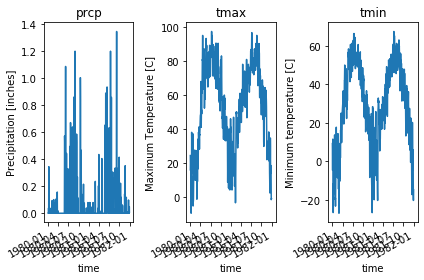

In [11]:
fig, ax = plt.subplots(ncols=3)
t_hru = 13
prms6bmi.plot_climate(clim, t_hru, 'prcp', sim_start_date, sim_end_date, ax[0])
prms6bmi.plot_climate(clim, t_hru, 'tmax', sim_start_date, sim_end_date, ax[1])
prms6bmi.plot_climate(clim, t_hru, 'tmin', sim_start_date, sim_end_date, ax[2])
plt.tight_layout()
plt.show()

### Plot a comparison of the 4 variables that are passed between the surface and soil bmi's and check the residual compared to the regular PRMS6 run
1. The hru to plot can be adjusted by setting t_hru. There are 14 hrus.

### Parameters passed from bmi-soil to bmi-surface
#### From climateflow class
1. soil_moist: Storage of capillary reservoir for each HRU
2. soil_rechr: Storage for recharge zone (upper portion) of the capillary reservoir that is available for both evaporation and transpiration

#### From runoff class
3. infil: Infiltration to the capillary reservoir for each HRU
4. sroff: Surface runoff to the stream network for each HRU


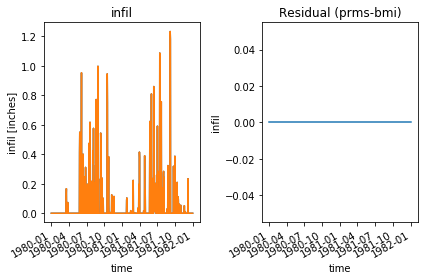

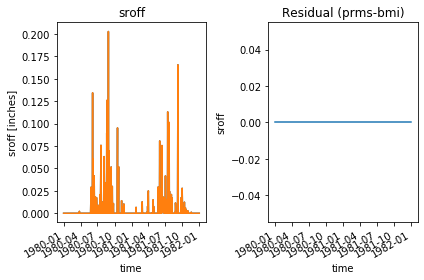

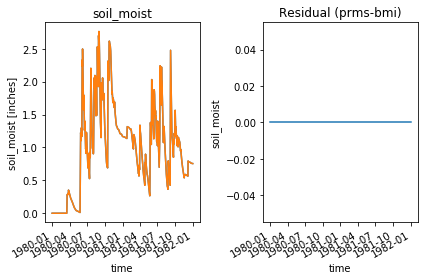

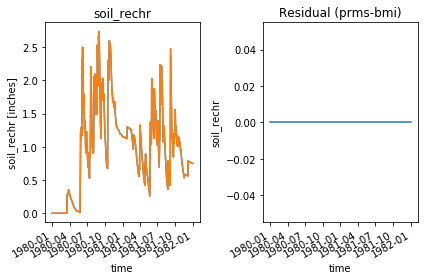

In [13]:
t_hru = 13

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_test_compare_plot_hru(dsoil, dprms, t_hru, 'infil', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_test_compare_residual_plot_hru(dsoil, dprms, t_hru, 'infil', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_test_compare_plot_hru(dsoil, dprms, t_hru, 'sroff', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_test_compare_residual_plot_hru(dsoil, dprms, t_hru, 'sroff', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_test_compare_plot_hru(dsoil, dprms, t_hru, 'soil_moist', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_test_compare_residual_plot_hru(dsoil, dprms, t_hru, 'soil_moist', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_test_compare_plot_hru(dsoil, dprms, t_hru, 'soil_rechr', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_test_compare_residual_plot_hru(dsoil, dprms, t_hru, 'soil_rechr', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

### Plot a comparison some other variables in the surface and soil zones
1. The hru to plot can be adjusted by setting t_hru. There are 14 hrus.

### Parameters passed from bmi-soil to bmi-surface
#### From soil class
1. soil_to_gw: Storage of capillary reservoir for each HRU
2. ssr_to_gw: Portion of excess flow to the capillary reservoir that drains to the associated GWR for each HRU

#### From Evapotranspiration class
3. dprst_evap_hru: Evaporation from surface-depression storage for each HRU

#### From the Surface Depression Storage Class
4. dprst_seep_hru: Seepage from surface-depression storage to associated GWR for each HRU


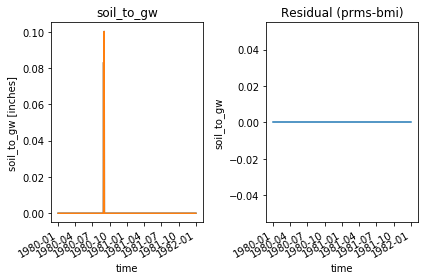

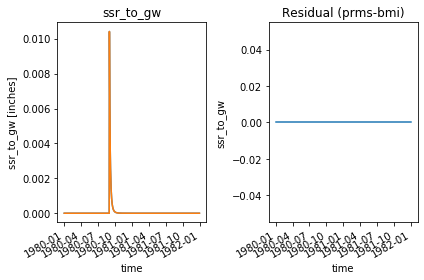

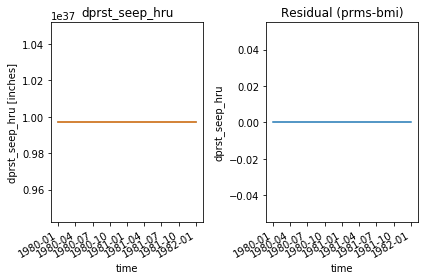

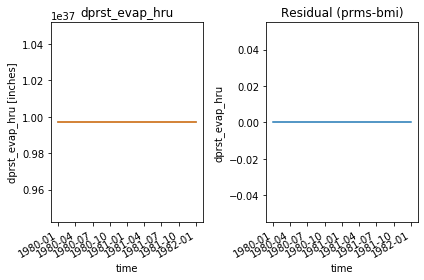

In [14]:
fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_test_compare_plot_hru(dsoil, dprms, t_hru, 'soil_to_gw', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_test_compare_residual_plot_hru(dsoil, dprms, t_hru, 'soil_to_gw', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_test_compare_plot_hru(dsoil, dprms, t_hru, 'ssr_to_gw', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_test_compare_residual_plot_hru(dsoil, dprms, t_hru, 'ssr_to_gw', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_test_compare_plot_hru(dsoil, dprms, t_hru, 'dprst_seep_hru', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_test_compare_residual_plot_hru(dsoil, dprms, t_hru, 'dprst_seep_hru', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2)
prms6bmi.bmi_test_compare_plot_hru(dsoil, dprms, t_hru, 'dprst_evap_hru', sim_start_date, sim_end_date, ax[0])
prms6bmi.bmi_test_compare_residual_plot_hru(dsoil, dprms, t_hru, 'dprst_evap_hru', sim_start_date, sim_end_date, ax[1])
plt.tight_layout()
plt.show()